# <div style="text-align: center"> PROYECTO FINAL </div>  
<div style="text-align: center"> Alejandro Alayón Suárez - 201316083</div>
___

## 1. Introducción

<div style="text-align: justify">
En la ingeniería de materiales existen múltiples maneras de mejorar las propiedades de un material,
entre las cuales se encuentran tratamientos térmicos, deformaciones, compuestos, recubrimientos,
ente otros. De los procesos nombrados los recubrimientos se han popularizado en las últimas décadas
debido a su simplicidad, efectividad y conservación de las propiedades internas del material original.
Usualmente, los recubrimientos son utilizados para mejorar propiedades superficiales (dureza,
conductividad térmica, conductividad eléctrica etc.) mientras preservan propiedades bulk como la
elasticidad y resistencia a la tensión. Los métodos de aplicación más comunes para dicho tratamiento
son deposición química, spray a alta presión y spray a baja presión. De todos los mecanismos mencionados, los de spray a baja presión son los más simples debido a que
no deforman la superficie del material como lo hacen los de alta presión y no requieren equipos
complejos como los de deposición química. Sin embargo, la homogeneidad y efectividad del
recubrimiento es difícil de alcanzar utilizando dicha técnica por lo que suele ser necesario
experimentación previa para comprobar visualmente cuantas capas de material deben ser aplicadas.</div>

<div style="text-align: justify">
Es por esto, que el análisis y procesamiento digital de imágenes por medio de Python se presenta como una herramienta de gran utilidad para determinar la efectividad porcentual de un recubrimiento sobre un material. En el presente proyecto se muestra la utilización de herramientas de binarización, transformación morfológica, clasificación y filtrado de imagenes junto con herramientas estadísticas las cuales son explicadas a continuación.
</div>


## 2. Paquetes

Los paquetes necesarios para la realización del proyecto fueron los siguientes:
- numpy: Es el paquete fundamental de cálculos matemáticos de python.
- pylab: Facilita la graficación y visualización de imagenes y gráficas.
- pyplot: Permite la graficación de datos.
- scipy: Paquete científico de python el cual permite procesamiento de imagenes.
- cv2: Paquete que permite el procesamiento e importacion de imagenes.

In [1]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
import scipy
import cv2
from scipy import misc
from scipy import ndimage

## 3. Importación de imagenes

El primer paso en la construcción del programa fue establecer una función que importe una imagen (formato .tif) y la convierta en una matriz de pixeles de dimensiones $n\times m$  en donde cada uno de los componenetes de la matriz es un vector de forma  $[R\space G\space B]$. Los componentes de dicho vector son números enteros entre **0** y **255** los cuales indican la intensidad del color que corresponde a cada letra del formato (**R**:rojo, **G**:verde y **B**:azul).

Adicionalmente la función debía transformar la imagen de color a una imagen en escala de grises con el objetivo de facilitar la implementación de las siguientes funciones. Al escalar una imagen a grises el vector  $[R\space G\space B]$ es simplificado a un único valor el cual es un indicativo de la luminosidad del pixel al cual le corresponde el vector. La función fue llamada _**imgimport**_ y es mostrada a continuación:

In [2]:
# IMPORTACIÓN DE IMAGENES & ESCALA DE GRISES

## Parámetros de entrada: Nombre del archivo de la imagen en formato .tif entre '.' sin incluir '.tif'.
## Retorna: Matriz de la imagen en escala de grises.

def imgimport(file):
    # La función imread de la librería cv2 importa la imagen en formato .tif
    img = cv2.imread(file+'.tif')
    # La función cvtColor con el parámetro COLOR_BGR2GRAY escala en grises la imagen
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return gray

## 4. Umbral de binarización

En el análisis y procesamiento de imágenes es común la implementación de binarizaciones (pasar de una imagen en escala de grises a una imagen completamente en blanco y negro) ya que permiten la diferenciación de formas al eliminar ruido y pixeles inciertos. La binarización funciona mediante la implementación de un umbral o _threshold_ sobre una imagen en escala de grises, dicho umbral establece un límite sobre el cual los pixeles serán negros (0), en caso contrario los pixeles serán blancos (255).


<img src="threshold.jpg">


Ahora bien, existen diversos metodos para el cálculo del umbral, entre los más utilizados se encuentra el umbral de Otsu en el cual un algoritmo calcula el histograma de la escala de grises sobre toda la matriz de la imagen la cual suele tener dos picos (pixeles negros y blancos) y posiciona el umbral en la mitad de ambos picos así ajustando la frontera a las características específicas de cada imagen.


<img src="otsu.jpg">


Para la binarizacion de la imagen se creo la función _**threshold**_ la cual es expuesta a continuación.

In [3]:
# UMBRAL Y BINARIZACIÓN

## Parámetros de entrada: Matriz de la imagen en escala de grises.
## Retorna: Matriz binarizada de la imagen.

def threshold(img_gray):
    # La función threshold de la librería cv2 aplica una binarización inversa de la imagen eligiendo un umbral por el método de Otsu.
    ret, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return thresh

## 5. Transformación morfológica

Las transformaciones morfológicas son operaciones simples basadas en la forma de una imagen las cuales ususlamente son aplicadas en imagenes binarizadas. Estas operaciones requieren dos parámetros de entrada, el primero es la imagen binarizada y el segundo es un elemento de estructuración o *kernel* el cual determina la naturaleza de la transformación. Las operaciones de transformación morfológica básicas son la erosión y la dilatación, de estas se derivan la apertura, el cerrado y el gradiente.

La apertura o _opening_ de una imagen consiste en aplicar una erosión seguida de una dilatación sobre una imagen, lo que provoca eliminación de ruido o pixeles inecesarios dependiendo del tamaño del kernel.


<img src="opening.png">

    
Ahora bien, debido a que el tamaño de las partículas en los recubrimientos varía dependiendo del material que se utilice, el kernel debe ser ajustado dependiendo del tamaño mínimo de particula. Esto con el objetivo de prevenir que las partículas más pequeñas seán eleminadas por la transformación morfológica. Para determinar los tamaños de kernel para cada tamaño de partícula se procedió de la siguiente manera:

### 5.1 Identificación de la escala

Como primer paso se calculó el tamaño de cada pixel en unidades del SI dada la escala de la imagen:

$Escala=\frac{0.22\times 1000}{973-634}=0.65 \frac{\mu m}{pixel}$

Vale aclarar que la función recibe como parámetro cualquier escala dada en una unidad métrica sobre pixel.

### 5.2 Cálculo del tamaño del kernel

Para el cálculo del tamaño del kernel se emplearon las dos funciones anterioirmente establecidas y la transformación morfológica de apertura con valores de kernel de 2 , 3 y 4 para lo cual se obtuvo que:

- Para un tamaño de kernel de 2 se reconocen partículas de hasta 2 $\mu m$
- Para un tamaño de kernel de 3 se reconocen partículas de hasta 8 $\mu m$
- Para un tamaño de kernel de 4 se reconocen partículas de hasta 21 $\mu m$

En la siguiente celda de código se puede apreciar como el tamaño del kernel afecta la transformación morfológica de la imagen.

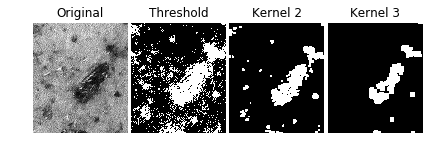

In [4]:
img_gris=imgimport('Laminillas')
crop = img_gris[1250:1600,500:800]
thresh=threshold(crop)

kernel1 = np.ones((2,2),np.uint8)
opening1 = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel1, iterations = 5)

kernel2 = np.ones((3,3),np.uint8)
opening2 = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel2, iterations = 5)

kernel3 = np.ones((4,4),np.uint8)
opening3 = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel3, iterations = 5)

plt.subplot(141)
plt.imshow(crop)
plt.title('Original')
plt.axis('off')
pylab.gray()
plt.subplot(142)
plt.imshow(thresh)
plt.title('Threshold')
plt.axis('off')
pylab.gray()
plt.subplot(143)
plt.imshow(opening1)
plt.title('Kernel 2')
plt.axis('off')
pylab.gray()
plt.subplot(144)
plt.imshow(opening2)
plt.title('Kernel 3')
plt.axis('off')
pylab.gray()
plt.subplots_adjust(wspace=0.04, hspace=0.02, top=1, bottom=0, left=0, right=0.9)
plt.show()

### 5.3 Apertura morfológica

Se creó la función __**morf_opening**__ con el objetivo de realizar el filtrado de ruido por medio de una apertura morfológica. Esta es expuesta a continuación.

In [5]:
# APERTURA MORFOLÓGICA

## Parámetros de entrada: Tamaño mínimo de partícula a detectar en micrómetros y matriz binarizada de la imagen.
## Retorna: Matriz binarizada filtrada por la apertura morfológica.

def morf_opening(p_size,thresh_hold):
    #Parametrización del tamaño del kernel dependiendo del tamaño de partícula
    m_size=0
    if p_size <= 8:
        m_size=2
    elif p_size <=21:
        m_size=3
    else:
        m_size=4
    #Creación del kernel dado el parámetro m_size   
    kernel = np.ones((m_size,m_size),np.uint8)
    #Apertura morfológica mediante la función morphologyEx e la librería cv2 con 5 iteraciones
    opening = cv2.morphologyEx(thresh_hold,cv2.MORPH_OPEN,kernel, iterations = 5)
    return opening

## 6. Porcentaje de superficie recubierta

Con el objetivo de calcular el porcentaje de superficie recubierta se implementó la función __**coat_pct**__ la cual cuenta el número de pixeles de recubrimiento (vale recordar que debido a la binarización inversa los pixeles blancos (255) son los correspondientes a las partes recubiertas de la imagen) tras la transformación morfológica y los divide entre la cantidad de pixeles totales  de la imagen.

In [6]:
# PORCENTAJE DE SUPERFICIE RECUBIERTA

## Parámetros de entrada: Matriz binarizada filtrada por la apertura morfológica.
## Retorna: Proporción de la superficie total recubierta (sin multiplicar por 100).

def coat_pct(opening):
    #La función nonzero() retorna las coordenadas de los pixeles blancos.
    coord_pxl=opening.nonzero()
    #Cálculo de las dimensiones totales de la imagen.
    lgth=len(opening)
    wdth=len(opening[0])
    #Conteo de la totalidad de pixeles recubiertos.
    coat_pixl=len(coord_pxl[0])
    #Cálculo del porcentaje de recubrimiento
    pct=coat_pixl/(lgth*wdth)
    return pct

## 7. Conteo y tamaño de áreas recubiertas

Con el objetivo de separar cada área recubierta y calcular su tamaño se implementó la función __**size_n_nmbr**__ la cual emplea la librería scipy con el objetivo de etiquetar o _label_ cada conjunto de pixeles diferentes a 0 (blancos) según un kernel dado, adicionalmente la librería tambien permite sumar los elementos de estas áreas para encontrar sus tamaños.

In [7]:
# CONTEO Y TAMAÑO DE ÁREAS RECUBIERTAS

## Parámetros de entrada: Matriz binarizada filtrada por la apertura morfológica.
## Retorna: Número de áreas detectadas y tamaños de dichas áreas.

def size_n_nmbr(opening):
    #La función ndimage.label de la librería scipy retorna las áreas recubiertas y la cantidad de áreas detectadas.
    label_im, nb_labels =scipy.ndimage.label(opening)
    #La función ndimage.sum de la librería scipy suma los componentes de las áreas recubiertas.
    sizes = ndimage.sum(opening, label_im, range(nb_labels + 1))
    #Se debe dividir los tamaños entre 255 (valor del color blanco) para normalizarlos en la cantidad de pixeles
    sizes=sizes/255
    return nb_labels , sizes

## 8. Histograma

La función _**histg**_ se creó con el objetivo de obtener estadísticas descriptivas como lo moda y la frecuencia de los tamaños de las áreas recubiertas, adicionalmente permite la graficación del histograma de dichas áreas lo cual implica tener un mejor entendimiento del recubrimiento.

In [8]:
# HISTOGRAMA

## Parámetros de entrada: Arreglo de los tamaños de las áreas recubiertas y escala de la imagen.
## Retorna: Histograma, moda y número de conteos de la moda.

def histg(sizes, escala):
    # La función plt.hist permite la graficación de un histograma dado un arreglo de datos y un número de separaciones.
    histo=plt.hist(sizes*escala,3000)
    # La moda y la frecuencia se obtienen calculando el máximo valor de repeticiones y posterioirmente extrayendo el dato correspondiente de área.
    counts=max(histo[0])
    indx=np.argmax(histo[0])
    mode=histo[1][indx]
    return histo, mode, counts

## 9. Herramienta de graficación

Considerando la complejidad de los datos numéricos se decidio diseñar una herramienta que presentara los siguientes datos de manera más amigable:

1. Histograma de la distribución de tamaños de áreas recubiertas.
2. Efectividad del recubrimiento (% de área recubierta)
3. Cantidad de áreas recubiertas detectadas.
4. Moda y conteos del tamaño de las áreas recubiertas.
5. Media y desviacion estandar de los tamaños de las áreas recubiertas.

Para esto se creó la función __**rslts_img**__ la cual es expuesta a continuación:

In [9]:
# HERRAMIENTA DE GRAFICACIÓN

## Parámetros de entrada: Tamaño mínimo de partícula en micrómetros, proporción de superficie recubierta, moda, conteos, media , desviación estandar, arreglo de tamaños de las áreas y escala.
## Retorna: Grafica de histograma y lista con: 
##1. Efectividad del recubrimiento (% de área recubierta)
##2. Cantidad de áreas recubiertas detectadas.
##3. Moda y conteos del tamaño de las áreas recubiertas.
##4. Media y desviacion estandar de los tamaños de las áreas recubiertas.

def rslts_img(tmño_part,prct,num_partic,mode,conteos,mu,sigma,tamaños,scales):
    #Creación de la figura
    fig = plt.figure()
    #Creación de la sub figura que contiene la lista de resultados
    ax = fig.add_subplot(122)
    fig.subplots_adjust(top=0.85)
    plt.axis('off')
    #Introducción a los resultados
    ax.text(0, 9, 'Para un tamaño mínimo de partícula de ' +str(tmño_part)+' $\mu$m se obtuvieron los siguientes resultados:', fontsize=12)
    #Porcentaje de recubrimiento
    ax.plot(0.3, 8.17, 'o', color='green')
    ax.text(1, 8, 'La efectividad del recubrimiento fue de ' +str(np.round(prct*100,2))+'%.', fontsize=12)
    #Número de partículas detectadas
    ax.plot(0.3, 7.18, 'o', color='green')
    ax.text(1, 7, 'Se detectaron '+str(num_partic)+ ' lugares recubiertos en la imagen analizada.', fontsize=12)
    #Moda y conteos de los tamaños de las partículas detectadas
    ax.plot(0.3, 6.19, 'o', color='green')
    ax.text(1, 6, 'La moda del tamaño de las areas recubiertas fue de '+str(np.round(mode,2))+ ' $\mu m^2$ con ' +str(np.round(conteos)) +' conteos registrados.', fontsize=12)
    #Media y desviación estamdar de los tamaños de las áreas recubiertas detectadas
    ax.plot(0.3, 5.20, 'o', color='green')
    ax.text(1, 5, 'La media del tamaño de las areas recubiertas fue de '+str(np.round(mu))+ ' $\mu m^2$ con un $\sigma$ de ' +str(np.round(sigma)) +' $\mu m^2$.', fontsize=12)
    # Ajuste del tamaño de la figura
    ax.axis([0, 10, 0, 10])
    #Creación de la sub figura que contiene el histograma
    bx = fig.add_subplot(121)
    bx.set_title('Histograma',fontweight='bold')
    plt.hist(tamaños*scales,3000)
    axes = plt.gca()
    axes.set_xlim([9,1000])
    plt.xlabel('Tamaños [$\mu m ^2$]')
    plt.ylabel('Frecuencia')
    plt.show()
    return fig

## 10. Unificación

Para finalizar se implementaron todas las funciones anterioires en una función unificadora con el objetivo de simplificar y organizar el código. Dicha función fue denominada _**recubrimiento**_ y es expuesta a continuación.

In [10]:
# UNIFICACIÓN

## Parámetros de entrada: nombre del archivo de la imagen (formato .tif), tamaño mínimo de partícula a detectar y escala de la imagen en micrómetros/pixel.
## Retorna: figura implementada en la herramienta de graficación. 

def recubrimiento(achvo,tmño_part,escala):
    # IMPORTACIÓN DE IMAGENES & ESCALA DE GRISES
    img_gris= imgimport(achvo)
    # UMBRAL Y BINARIZACIÓN
    thresh=threshold(img_gris)
    # APERTURA MORFOLÓGICA
    opening=morf_opening(tmño_part,thresh)
    # PORCENTAJE DE SUPERFICIE RECUBIERTA
    pct=coat_pct(opening)
    # CONTEO Y TAMAÑO DE ÁREAS RECUBIERTAS
    num_partic, tamaños = size_n_nmbr(opening)
    # HISTOGRAMA
    hist, moda, conteo = histg(tamaños, escala)
    # Cálculo de la media
    media=np.mean(tamaños*escala)
    # Cálculo de la desviación estandar
    sigma=np.std(tamaños*escala)
    plt.close()
    # HERRAMIENTA DE GRAFICACIÓN
    figura = rslts_img(tmño_part,pct,num_partic,moda,conteo,media,sigma,tamaños,escala)
    return figura

## 11. Ejemplos

A continuación se muestran algunos ejemplos del funcionamiento del algoritmo fabricada para la caracterización de recubrimientos.

En primer lugar se implementa un valor para la escala.

In [11]:
scale=((1/4.5)*1000)/(973-634)

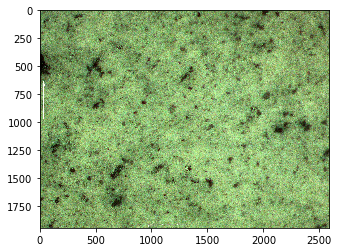

In [12]:
img1 = cv2.imread('Laminillas.tif')
plt.imshow(img1)
plt.show()

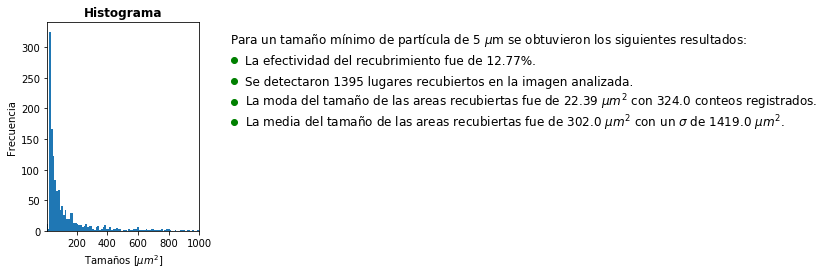

In [13]:
a =recubrimiento('Laminillas',5,scale)

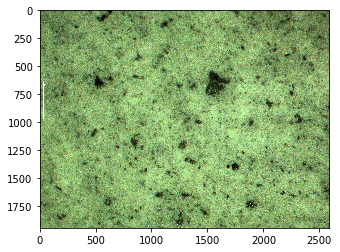

In [14]:
img2 = cv2.imread('Laminillas1.tif')
plt.imshow(img2)
plt.show()

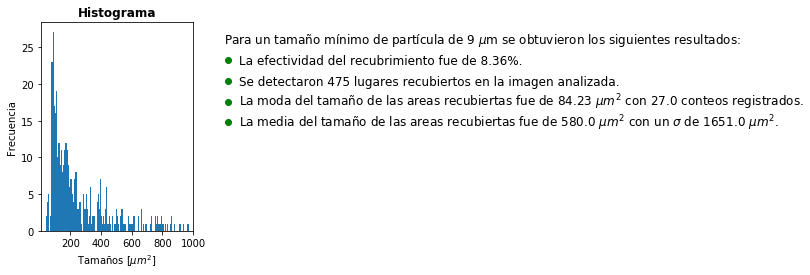

In [15]:
b =recubrimiento('Laminillas1',9,scale)

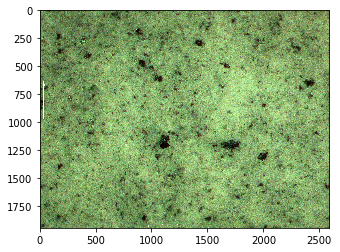

In [16]:
img3 = cv2.imread('Laminillas2.tif')
plt.imshow(img3)
plt.show()

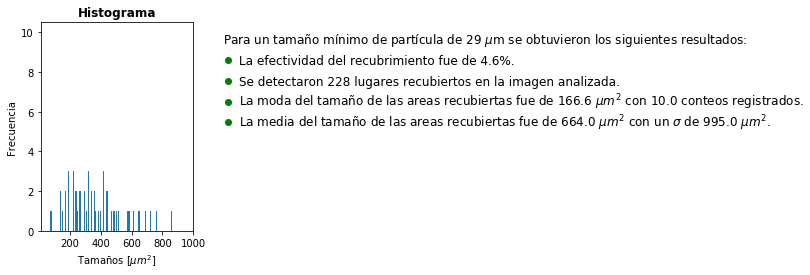

In [17]:
c =recubrimiento('Laminillas2',29,scale)